# KL Дивергенция

In [1]:
P = [.05, .1, .2, .05, .15, .25, .08, .12]
Q = [.3, .1, .2, .1, .1, .02, .08, .1]

from scipy.special import rel_entr

sum(rel_entr(P, Q))

0.589885181619163

In [2]:
sum(rel_entr(Q, P))

0.497549319448034

In [3]:
from typing import Dict, Any

import os
from tqdm import tqdm
import cv2
import einops
import numpy as np
import json
from time import sleep
from sklearn.metrics import accuracy_score, roc_auc_score

import torch
import torch.nn.functional as FF
import torch.nn.utils.parametrize as P
from torch.utils.data import IterableDataset, DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image 
import pandas as pd

from skimage import io
import matplotlib.pyplot as plt

In [4]:
names = {
    "QR_Тест_ТЕСТОВОЕ_ ТЕСТВО_[НВ_2 оч_13 ж.д.]_1_9_118_XXXxxx_07-10-23_ot.mp4": False,
    "QR_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_11_118_AzPmRG_21-10-23_decor.mp4": True,
    "QR_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_9_118_qoY4P8_07-10-23_decor.mp4": True,
    "QR_Москва_ОСТАФЬЕВО_[ОСТ_4 оч_13 ж.д.]_5_9_126_lxMLNd_14-10-23_decor.mp4": True,
    "QR_Тестовая обл._ТЕСТ ТЕСТОВОЕ_[ПЛ_6 оч_1 эт_8.1 ж.д.]_1_9_127_B032TF_06-10-23_ot.mp4": False,
    "Москва_ОСТАФЬЕВО_12.3_2_3-1KSipF_-23-02-23.mp4": True,
    'Москва_ОСТАФЬЕВО_12.3_2_3-291rgq9-23-02-23.mp4': True,
    'Москва_ОСТАФЬЕВО_12.3_2_3-3aeI6Lw-23-02-23.mp4': True,
    'Москва_ОСТАФЬЕВО_12.3_2_3-41TezHv-23-02-23.mp4': True,
    'Москва_ОСТАФЬЕВО_12.3_2_4-1XIdkZ7-23-02-23.mp4': True,
    'Москва_ОСТАФЬЕВО_12.3_2_4-2DDlOz--23-02-23.mp4': True,
    'Москва_ОСТАФЬЕВО_12.3_2_4-30O1k1_-23-02-23.mp4': True,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_0vAQQ6_11-01-24_decor.mp4': True,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_AMQxnF_11-01-24_decor.mp4': True,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_B3Mrft_11-01-24_decor.mp4': True,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_6_117_6qaY4J_11-01-24_decor.mp4': True,
    'Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_6_117_Q0zv1E_11-01-24_decor.mp4': True
}

def video_iterator_helper(
    each_k: int, 
    video_dir: str
):
    
    for video_path in os.listdir(video_dir):
        cap = cv2.VideoCapture(video_dir + "/" + video_path)
        cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        if cnt > 9:
        
            ct = cnt
            while ct % 9 != 0:
                ct -= 1

            print(video_path, fps, cnt)
            counter = 1
            while cap.isOpened() and (counter <= ct):
                ret, frame = cap.read()
                
                if names[video_path]:
                    frame = cv2.flip(frame, 0)
                    frame = cv2.flip(frame, 1)

                if ret and counter % 3 == 0:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    yield counter, frame
                if not ret:
                    break
                counter += 1
        cap.release()

class VideoIterDataset(IterableDataset):
    def __init__(self, each_k: int = 1, video_dir: str = "None"):
        self._each_k = each_k
        self._video_dir = video_dir

    def __iter__(self):
        it = video_iterator_helper(self._each_k, self._video_dir)
        return it

def tranform_batch(batch, resize_to=(384, 384)):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    batch = (batch / 255.)
    batch = FF.interpolate(einops.rearrange(batch, 'b h w c -> b c h w'), size=resize_to, mode='bicubic', align_corners=False)
    new_batch = (batch - mean) / std
    
    return new_batch, batch

In [5]:
@torch.inference_mode()
def predict_video(
    each_k: int,
    val_mode: bool,
    model_data: Dict[str, Any], 
    batch_size: int,
    device: torch.device
):
    k = 0
    model = model_data['model'].to(device)
    
    if val_mode:
        video_dir, frame_dir, labeled_frame_dir = "val_videos", "frames/test", "val_labeled_frames"
    else:
        video_dir, frame_dir, labeled_frame_dir = "videos", "frames/train", "labeled_frames"
        
    dataset = VideoIterDataset(each_k, video_dir)
    
    print(video_dir, frame_dir)
    loader = DataLoader(dataset, batch_size=batch_size)
    probs = []
    frame_dic = {"frame": {}}
    batch_counter = 0
    for indices, batch in loader:
        indices = indices.tolist()
        new_transformed, transformed = tranform_batch(batch, model_data['resize_to'])
        new_transformed = new_transformed.to(device)
        transformed = transformed.to(device)
        try:
            os.mkdir(frame_dir + "/" + str(batch_counter))
        except Exception:
            print('Already exists: ', frame_dir + "/" + str(batch_counter))
        
        for ind_frame_tens in range(len(transformed)):
            transform = T.ToPILImage()
            frame = transform(transformed[ind_frame_tens])
            frame.save(frame_dir + "/" + str(batch_counter) + "/" + str(ind_frame_tens) + ".png")
        
        try:
            os.mkdir(labeled_frame_dir + "/" + str(batch_counter))
        except Exception:
            print('Already exists: ', labeled_frame_dir + "/" + str(batch_counter))
        
        logits = model(new_transformed)
        res = logits.sigmoid().cpu().clone().detach()
        
        for frame in range(len(batch)):
            frame_dic["frame"][frame] = {}
            preds = res[frame].clone().detach()
            frame_dic["frame"][frame]["all_probs"] = preds.tolist()
            
            frame_json = json.loads(json.dumps(frame_dic))
            
        with open(labeled_frame_dir + "/" + str(batch_counter) + "/" + "target.txt", "w") as f:
            json.dump(frame_dic, f)
            
        probs.append(res)
        batch_counter += 1
    probs = torch.concat(probs).numpy()
    
    return probs

In [8]:
params = {
    'each_k': 1,
    'device': torch.device('cuda:0'),
    'batch_size': 3,
    'val_mode': True,
    'model_data': {
        'name': 'mobilenet_v3',
        'model': torch.jit.load(
            './models/models/convnext_base.clip_laion2b_augreg_ft_in12k_in1k_scripted.pt'
        ).eval(),
        'resize_to': (224, 224)
    },
    
}

In [9]:
class_probs = predict_video(**params)

val_videos frames/test
Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_0vAQQ6_11-01-24_decor.mp4 30.004648350746926 1646.0
Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_AMQxnF_11-01-24_decor.mp4 30.004563028152823 1508.0
Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_1_117_B3Mrft_11-01-24_decor.mp4 30.009487255561975 1842.0
Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_6_117_6qaY4J_11-01-24_decor.mp4 30.004615272849517 11234.0
Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_6_117_Q0zv1E_11-01-24_decor.mp4 30.004596965428522 10217.0


### Анализ таргета test

In [141]:
import json
train_label = os.listdir("val_labeled_frames")

train_jsons = []
for file in train_label:
    f = open("val_labeled_frames" + "/" + file + "/" + "target.txt")
    data = json.load(f)
    train_jsons.append(data)

frames = []
classes = [[] for i in range(len(train_jsons[0]["frame"]["0"]['all_probs']))]
videos = []
j = 0
for file in train_jsons:
    for key in file["frame"]:
        videos.append(j)
        frames.append(key)
        for i in range(len(file["frame"][str(key)]['all_probs'])):
            classes[i].append(file["frame"][str(key)]["all_probs"][i])
    j+=1
    
series = {"video": videos, "frame": frames}
for i in range(len(classes)):
    series[i] = classes[i]
    
target_df = pd.DataFrame(series)
target_df["frame"] = target_df["frame"].astype(int)
target_df.head(6)

{'0': {'all_probs': [0.006206464022397995,
   3.163323526678141e-06,
   0.00021048328198958188,
   0.0010919974884018302,
   0.0008620157022960484,
   3.228388550269301e-06,
   1.783178413461428e-05,
   0.3298319876194,
   0.011377772316336632,
   1.1942001947318204e-05,
   7.52341065890505e-06,
   9.8033831363864e-07,
   0.004105465952306986,
   2.6947207132366202e-08,
   0.00018611233099363744,
   0.0988420695066452,
   3.930279490305111e-05,
   4.438918040250428e-05,
   0.023010825738310814,
   0.9662594199180603,
   2.6019935830845498e-05,
   0.0003328878665342927,
   5.059953036834486e-05,
   5.9804664488183334e-05,
   2.422488705633441e-06,
   2.5999718218372436e-06,
   4.24502673013194e-07,
   7.614465289407235e-07,
   1.1541956155269872e-06,
   2.9732767870882526e-05,
   0.0006620578933507204,
   6.283343282120768e-06,
   4.0394334064330906e-06,
   9.421495633432642e-05,
   0.004035734571516514,
   1.1436877684900537e-06,
   3.3178844205394853e-07,
   0.0039058802649378777,
   

In [143]:
target_df["all_targets"] = target_df.drop(["video", "frame"], axis=1).values.tolist()

def rel_entr_func(x):
    x = x.reset_index()
    P = x.iloc[1]["all_targets"].copy()
    Q = x.iloc[2]["all_targets"].copy()
    return sum(rel_entr(P, Q))

# target rate
target_df_grouped = target_df[["video", "all_targets"]].groupby("video").agg(lambda x: rel_entr_func(x)).reset_index()
target_df_grouped = target_df_grouped.rename(columns={"all_targets": "kl"})

target_df = pd.merge(target_df, target_df_grouped, on="video", how="left")
target_df["target"] = np.where(target_df["kl"] < 1, 1, 0)
target_df[target_df["frame"] == 2].groupby("target").count()

In [144]:
target_df[target_df["frame"] == 2].groupby("target").count()

,video,frame,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,all_targets,kl
target,,,,,,,,,,,,,,,,,,,,,
0,774,774,774,774,774,774,774,774,774,774,...,774,774,774,774,774,774,774,774,774,774
1,2162,2162,2162,2162,2162,2162,2162,2162,2162,2162,...,2162,2162,2162,2162,2162,2162,2162,2162,2162,2162


### Анализ таргета train

In [5]:
import json
train_label = os.listdir("labeled_frames")

train_jsons = []
for file in train_label:
    f = open("labeled_frames" + "/" + file + "/" + "target.txt")
    data = json.load(f)
    train_jsons.append(data)
train_jsons[0]["frame"]

{'0': {'all_probs': [0.1684272140264511,
   0.00010133361502084881,
   7.122266106307507e-05,
   0.005481462460011244,
   8.372734009753913e-05,
   0.001502064522355795,
   1.3226317605585791e-05,
   9.553636482451111e-05,
   0.013600618578493595,
   5.5756474466761574e-05,
   7.694560736126732e-06,
   3.757021204364719e-06,
   0.00026741295005194843,
   1.2586021114202595e-07,
   3.411439320188947e-05,
   0.3530382513999939,
   0.34553098678588867,
   0.6959304213523865,
   5.84920599067118e-05,
   0.005410891491919756,
   0.00041925485129468143,
   0.00012321716349106282,
   0.0003772718191612512,
   0.0008012605248950422,
   3.985905095760245e-06,
   2.0417513951542787e-05,
   8.841639100864995e-07,
   5.7308516261400655e-05,
   6.477155238826526e-06,
   4.995094059268013e-06,
   1.8123733752872795e-05,
   1.406651244906243e-05,
   4.43425087723881e-05,
   0.0006664841203019023,
   0.0006170601118355989,
   0.0008207614882849157,
   1.0073576049762778e-05,
   3.502198524074629e-05,


In [6]:
frames = []
classes = [[] for i in range(len(train_jsons[0]["frame"]["0"]['all_probs']))]
videos = []
j = 0
for file in train_jsons:
    for key in file["frame"]:
        videos.append(j)
        frames.append(key)
        for i in range(len(file["frame"][str(key)]['all_probs'])):
            classes[i].append(file["frame"][str(key)]["all_probs"][i])
    j+=1
    
series = {"video": videos, "frame": frames}
for i in range(len(classes)):
    series[i] = classes[i]
    
target_df = pd.DataFrame(series)
target_df["frame"] = target_df["frame"].astype(int)
target_df.head(6)

,video,frame,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,0,0,0.168427,0.000101,0.000071,0.005481,0.000084,0.001502,0.000013,0.000096,...,0.000010,0.951730,2.169662e-07,0.000011,0.000033,0.000336,0.000120,0.997666,0.000013,1.390413e-06
1,0,1,0.000655,0.000333,0.000518,0.008825,0.000110,0.000302,0.000002,0.000163,...,0.000009,0.578485,1.087981e-07,0.000009,0.000043,0.000216,0.000028,0.992443,0.000010,3.563218e-07
2,0,2,0.000191,0.000714,0.000161,0.010883,0.000080,0.003035,0.000002,0.000093,...,0.000017,0.979227,4.840757e-07,0.000004,0.000192,0.000136,0.000010,0.999298,0.000008,1.123586e-06
3,1,0,0.000624,0.213788,0.000101,0.000430,0.000060,0.003205,0.000001,0.000140,...,0.000009,0.957516,3.695551e-07,0.000002,0.000053,0.000068,0.000019,0.980477,0.000007,1.391055e-07
4,1,1,0.003870,0.425210,0.000026,0.000106,0.000148,0.004073,0.000005,0.000100,...,0.000011,0.925571,9.511266e-07,0.000002,0.000044,0.000148,0.000050,0.900838,0.000007,4.546611e-07
5,1,2,0.008464,0.320615,0.000010,0.000016,0.000190,0.010343,0.000003,0.000032,...,0.000012,0.997925,8.006456e-07,0.000003,0.000023,0.000254,0.000023,0.461531,0.000008,5.544875e-07


In [ ]:
device = torch.device("cpu")
crnn_cpu_eval = RNN_NET().to(device)
crnn_cpu_eval.load_state_dict(torch.load("./model_10_10_2024.pt"))
crnn_cpu_eval.eval()

In [ ]:
img_1 = io.imread(r"./frames/train/140/0.png")
img_2 = io.imread(r"./frames/train/140/1.png")
img_3 = io.imread(r"./frames/train/140/2.png")

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(10, 10))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(img_3)

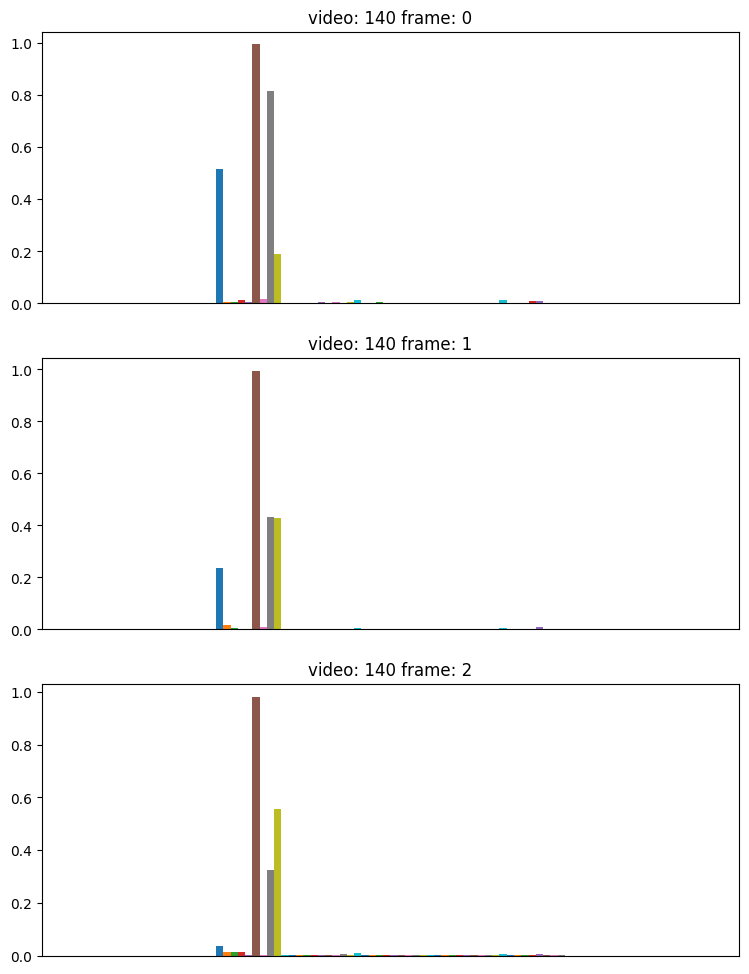

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(9, 12))

target_df[(target_df["video"] == 140) & 
          (target_df["frame"] == 0)].drop(["video", "frame"], axis=1).plot(kind="bar", legend=False, ax=ax[0], title="video: " + str(140) + " frame: " + str(0))
ax[0].set_xticks([], [])
target_df[(target_df["video"] == 140) & 
          (target_df["frame"] == 1)].drop(["video", "frame"], axis=1).plot(kind="bar", legend=False, ax=ax[1], title="video: " + str(140) + " frame: " + str(1))
ax[1].set_xticks([], [])
target_df[(target_df["video"] == 140) & 
          (target_df["frame"] == 2)].drop(["video", "frame"], axis=1).plot(kind="bar", legend=False, ax=ax[2], title="video: " + str(140) + " frame: " + str(2))
ax[2].set_xticks([], [])
plt.show()

In [21]:
image_1 = Image.open(r"./frames/train/140/0.png")
image_1 = T.Compose([T.ToTensor()])(image_1)

image_2 = Image.open(r"./frames/train/140/1.png")
image_2 = T.Compose([T.ToTensor()])(image_2)

image_3 = Image.open(r"./frames/train/140/2.png")
image_3 = T.Compose([T.ToTensor()])(image_3)

In [22]:
crnn_cpu_eval(torch.stack((image_1, image_2, image_3)))

tensor([-1.0988,  0.8845], grad_fn=<AddBackward0>)

In [51]:
target_df[(target_df["video"] == 140) & 
          (target_df["frame"] == 0)]

,video,frame,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
420,140,0,0.514652,0.00541,0.005602,0.013939,0.004345,0.994422,0.018236,0.816963,...,0.000398,0.011632,0.00008,0.001314,0.000822,0.010613,0.010141,0.001269,0.001906,0.002274


In [53]:
P = target_df.drop(["video", "frame"], axis=1).iloc[421].values.flatten().tolist()
Q = target_df.drop(["video", "frame"], axis=1).iloc[422].values.flatten().tolist()

from scipy.special import rel_entr

sum(rel_entr(P, Q))

0.47159859408006877

In [ ]:
img_1 = io.imread(r"./frames/train/143/0.png")
img_2 = io.imread(r"./frames/train/143/1.png")
img_3 = io.imread(r"./frames/train/143/2.png")

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(10, 10))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(img_3)

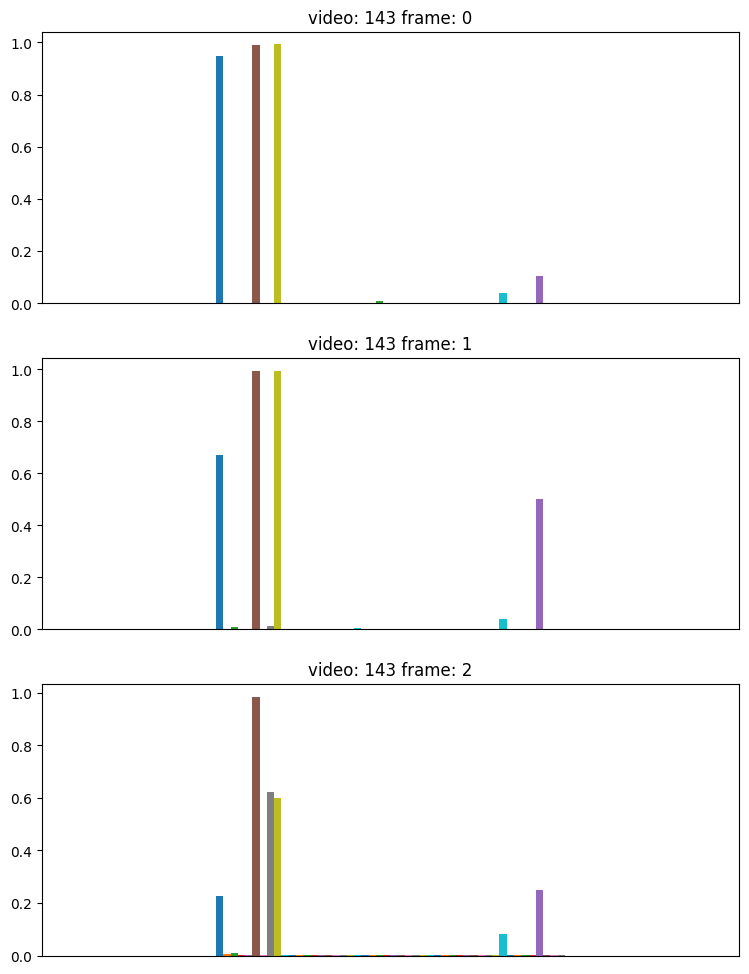

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(9, 12))

target_df[(target_df["video"] == 143) & 
          (target_df["frame"] == 0)].drop(["video", "frame"], axis=1).plot(kind="bar", legend=False, ax=ax[0], title="video: " + str(143) + " frame: " + str(0))
ax[0].set_xticks([], [])
target_df[(target_df["video"] == 143) & 
          (target_df["frame"] == 1)].drop(["video", "frame"], axis=1).plot(kind="bar", legend=False, ax=ax[1], title="video: " + str(143) + " frame: " + str(1))
ax[1].set_xticks([], [])
target_df[(target_df["video"] == 143) & 
          (target_df["frame"] == 2)].drop(["video", "frame"], axis=1).plot(kind="bar", legend=False, ax=ax[2], title="video: " + str(143) + " frame: " + str(2))
ax[2].set_xticks([], [])
plt.show()

In [13]:
image_1 = Image.open(r"./frames/train/143/0.png")
image_1 = T.Compose([T.ToTensor()])(image_1)

image_2 = Image.open(r"./frames/train/143/1.png")
image_2 = T.Compose([T.ToTensor()])(image_2)

image_3 = Image.open(r"./frames/train/143/2.png")
image_3 = T.Compose([T.ToTensor()])(image_3)

In [14]:
crnn_cpu_eval(torch.stack((image_1, image_2, image_3)))

tensor([ 1.4900, -1.6463], grad_fn=<AddBackward0>)

In [79]:
target_df[(target_df["video"] == 143) & 
          (target_df["frame"] == 1)].drop(["video", "frame"], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
430,0.669355,0.002523,0.011045,0.000043,0.000551,0.995522,0.000101,0.012509,0.993236,0.000275,...,0.000017,0.038314,0.000005,0.000015,0.000038,0.000283,0.503155,0.000164,0.000055,0.000057


In [80]:
target_df[(target_df["video"] == 143) & 
          (target_df["frame"] == 2)].drop(["video", "frame"], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
431,0.22653,0.005138,0.008696,0.001103,0.001687,0.985022,0.000715,0.621903,0.599045,0.000815,...,0.000076,0.082157,0.000013,0.000208,0.000188,0.002556,0.250618,0.000346,0.000303,0.000108


In [16]:
P = target_df.drop(["video", "frame"], axis=1).iloc[430].values.flatten().tolist()
Q = target_df.drop(["video", "frame"], axis=1).iloc[431].values.flatten().tolist()

from scipy.special import rel_entr

sum(rel_entr(P, Q))

1.506819348352728

In [126]:
target_df["all_targets"] = target_df.drop(["video", "frame"], axis=1).values.tolist()

def rel_entr_func(x):
    x = x.reset_index()
    P = x.iloc[1]["all_targets"].copy()
    Q = x.iloc[2]["all_targets"].copy()
    return sum(rel_entr(P, Q))

# target rate
target_df_grouped = target_df[["video", "all_targets"]].groupby("video").agg(lambda x: rel_entr_func(x)).reset_index()
target_df_grouped = target_df_grouped.rename(columns={"all_targets": "kl"})

target_df = pd.merge(target_df, target_df_grouped, on="video", how="left")
target_df["target"] = np.where(target_df["kl"] < 1, 1, 0)

In [140]:
target_df[target_df["frame"] == 2].groupby("target").count()

,video,frame,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,all_targets,kl
target,,,,,,,,,,,,,,,,,,,,,
0,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161,...,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161
1,1919,1919,1919,1919,1919,1919,1919,1919,1919,1919,...,1919,1919,1919,1919,1919,1919,1919,1919,1919,1919


In [ ]:
# предсказание верно!

In [ ]:
from skimage import io
img = io.imread(r"./frames/train/49/1.png")
plt.imshow(img)

In [ ]:
from skimage import io
img = io.imread(r"./frames/train/49/2.png")
plt.imshow(img)

In [ ]:
# значение таргета не истинное - базовая модель тоже может ошибаться, ввиду чего есть ошибка проставления таргета.

### Инференс сжатия видео

In [8]:
import torch.nn as nn
from sklearn.metrics import f1_score

class RNN_NET(nn.Module):
    def __init__(self):
        super().__init__()
        
        model = torch.load(
            './models/models/convnext_base.clip_laion2b_augreg_ft_in12k_in1k_scripted.pt'
        )
                    
        childs = []
        for child in model.children():
            for nested_child in child.children():
                if str(nested_child) not in [
                    "RecursiveScriptModule(original_name=Identity)",
                    "RecursiveScriptModule(original_name=Dropout)",
                    "RecursiveScriptModule(original_name=Linear)"
                ]:
                    childs.append(nested_child)
                    
        self.backbone = nn.Sequential(*childs)
        
        self.fc_1 = nn.Linear(1024, 512)
        
        self.rnn = nn.RNN(512, 512, 1, batch_first=True, bidirectional=False)
        
        self.fc_2 = nn.Linear(1024, 256)
        self.fc_3 = nn.Linear(256, 2)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        with torch.no_grad():
            x = self.backbone(x)
        
        x = self.relu(self.fc_1(x))
        
        x, hn = self.rnn(x, None)
        x_mean = torch.mean(x, dim=0)
        x_max = torch.max(x, dim=0)[0]
        
        x = torch.cat((x_mean, x_max), dim=0)
        
        x = self.relu(self.fc_2(x))
        
        x = self.fc_3(x)
        
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crnn_eval = RNN_NET().to(device)
crnn_eval.load_state_dict(torch.load("./model_11_10_2024.pt"))
crnn_eval.eval()

In [6]:
inference_video_path = "./Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_6_117_6qaY4J_11-01-24_decor.mp4"

names = {
    inference_video_path: True
}

def inf_video_iterator_helper(
    each_k: int
):
    cap = cv2.VideoCapture(inference_video_path)
    cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)

    print(inference_video_path, fps, cnt)
    counter = 1
    while cap.isOpened():
        ret, frame = cap.read()

        if names[inference_video_path]:
            frame = cv2.flip(frame, 0)
            frame = cv2.flip(frame, 1)

        if ret and counter % 3 == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            yield counter, frame
        if not ret:
            break
        counter += 1
    cap.release()

class VideoIterDatasetInf(IterableDataset):
    def __init__(self, each_k: int = 1):
        self._each_k = each_k

    def __iter__(self):
        it = inf_video_iterator_helper(self._each_k)
        return it

def inf_tranform_batch(batch, resize_to=(224, 224)):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    batch = (batch / 255.)
    batch = FF.interpolate(einops.rearrange(batch, 'b h w c -> b c h w'), size=resize_to, mode='bicubic', align_corners=False)
    new_batch = (batch - mean) / std
    
    return new_batch, batch

In [7]:
@torch.inference_mode()
def inf_predict_video(
    each_k: int,
    val_mode: bool,
    model_data: Dict[str, Any], 
    batch_size: int,
    device: torch.device
):
    k = 0
    model = model_data['model'].to(device)
    
    frame_dir, labeled_frame_dir = "frames/inference", "inf_labeled_frames"
        
    dataset = VideoIterDatasetInf(each_k)
    
    print(frame_dir)
    loader = DataLoader(dataset, batch_size=batch_size)
    probs = []
    frame_dic = {"frame": {}}
    probs_dic = {"0": [], "1": [], "2": []}
    batch_counter = 0
    for indices, batch in loader:
        indices = indices.tolist()
        new_transformed, transformed = inf_tranform_batch(batch, model_data['resize_to'])
        new_transformed = new_transformed.to(device)
        transformed = transformed.to(device)
        
        if batch_counter == 0:
            try:
                os.mkdir(frame_dir + "/" + str(batch_counter + 2))
            except Exception:
                print('Already exists: ', frame_dir + "/" + str(batch_counter + 2))
                
            transform = T.ToPILImage()
            frame = transform(transformed[0])
            frame.save(frame_dir + "/" + str(batch_counter + 2) + "/" + str(0) + ".png")
                
            try:
                os.mkdir(labeled_frame_dir + "/" + str(batch_counter + 2))
            except Exception:
                print('Already exists: ', labeled_frame_dir + "/" + str(batch_counter + 2))
                
            logits = model(new_transformed)
            res = logits.sigmoid().cpu().clone().detach()

            preds = res[0].clone().detach()
            probs_dic[str(0)] = preds.tolist()
        
        elif batch_counter == 1:
            
            try:
                os.mkdir(frame_dir + "/" + str(batch_counter + 2))
            except Exception:
                print('Already exists: ', frame_dir + "/" + str(batch_counter + 2))
                
            transform = T.ToPILImage()
            frame = transform(transformed[0])
            frame.save(frame_dir + "/" + str(batch_counter + 2) + "/" + str(0) + ".png")
            frame.save(frame_dir + "/" + str(batch_counter + 1) + "/" + str(1) + ".png")
            
            try:
                os.mkdir(labeled_frame_dir + "/" + str(batch_counter + 2))
            except Exception:
                print('Already exists: ', labeled_frame_dir + "/" + str(batch_counter + 2))
                
            logits = model(new_transformed)
            res = logits.sigmoid().cpu().clone().detach()

            preds = res[0].clone().detach()
            probs_dic[str(1)] = preds.tolist()
            
        else:
            try:
                os.mkdir(frame_dir + "/" + str(batch_counter + 2))
            except Exception:
                print('Already exists: ', frame_dir + "/" + str(batch_counter + 2))
                
            transform = T.ToPILImage()
            frame = transform(transformed[0])
            frame.save(frame_dir + "/" + str(batch_counter + 2) + "/" + str(0) + ".png")
            frame.save(frame_dir + "/" + str(batch_counter + 1) + "/" + str(1) + ".png")
            frame.save(frame_dir + "/" + str(batch_counter) + "/" + str(2) + ".png")
            
            try:
                os.mkdir(labeled_frame_dir + "/" + str(batch_counter + 2))
            except Exception:
                print('Already exists: ', labeled_frame_dir + "/" + str(batch_counter + 2))
                
            logits = model(new_transformed)
            res = logits.sigmoid().cpu().clone().detach()

            preds = res[0].clone().detach()
            probs_dic[str(2)] = preds.tolist()
        
        
            for frame in range(3):
                frame_dic["frame"][frame] = {}
                frame_dic["frame"][frame]["all_probs"] = probs_dic[str(frame)]

            frame_json = json.loads(json.dumps(frame_dic))
            
            with open(labeled_frame_dir + "/" + str(batch_counter) + "/" + "target.txt", "w") as f:
                json.dump(frame_dic, f)
            
            probs.append(res)
        batch_counter += 1
    probs = torch.concat(probs).numpy()
    
    return probs

In [8]:
params = {
    'each_k': 1,
    'device': torch.device('cuda:0'),
    'batch_size': 1,
    'val_mode': True,
    'model_data': {
        'name': 'mobilenet_v3',
        'model': torch.jit.load(
            './models/models/convnext_base.clip_laion2b_augreg_ft_in12k_in1k_scripted.pt'
        ).eval(),
        'resize_to': (224, 224)
    },
    
}

In [9]:
# class_probs = inf_predict_video(**params)
# удалить две последние папки

frames/inference
./Hand_Москва_НОВОЕ ВНУКОВО_[НВ_2 оч_13 ж.д.]_1_6_117_6qaY4J_11-01-24_decor.mp4 30.004615272849517 11234.0


C:\Users\itolo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1190: UserWarning: operator () profile_node %104 : bool = prim::profile_ivalue(%training.7)
 does not have profile information (Triggered internally at ..\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:109.)
  return forward_call(*input, **kwargs)


### Анализ инференса

In [10]:
import json
train_label = os.listdir("inf_labeled_frames")

train_jsons = []
for file in train_label:
    f = open("inf_labeled_frames" + "/" + file + "/" + "target.txt")
    data = json.load(f)
    train_jsons.append(data)

frames = []
classes = [[] for i in range(len(train_jsons[0]["frame"]["0"]['all_probs']))]
videos = []
j = 0
for file in train_jsons:
    for key in file["frame"]:
        videos.append(j)
        frames.append(key)
        for i in range(len(file["frame"][str(key)]['all_probs'])):
            classes[i].append(file["frame"][str(key)]["all_probs"][i])
    j+=1
    
series = {"video": videos, "frame": frames}
for i in range(len(classes)):
    series[i] = classes[i]
    
target_df = pd.DataFrame(series)
target_df["frame"] = target_df["frame"].astype(int)
target_df.head(6)

,video,frame,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,0,0,0.491662,0.000049,0.000289,0.109012,0.001047,0.033359,0.019175,0.993896,...,0.000016,0.004402,5.615262e-07,0.000121,0.000198,0.002263,0.000195,0.000050,0.000122,9.916663e-06
1,0,1,0.427265,0.000056,0.000640,0.080934,0.001881,0.013863,0.025211,0.990190,...,0.000022,0.006706,6.772058e-07,0.000298,0.000334,0.003480,0.000315,0.000100,0.000135,1.361463e-05
2,0,2,0.495510,0.000020,0.000852,0.229911,0.000145,0.032297,0.044483,0.999149,...,0.000032,0.979855,1.118655e-06,0.000328,0.000029,0.000502,0.000093,0.000767,0.000413,2.543146e-05
3,1,0,0.491662,0.000049,0.000289,0.109012,0.001047,0.033359,0.019175,0.993896,...,0.000016,0.004402,5.615262e-07,0.000121,0.000198,0.002263,0.000195,0.000050,0.000122,9.916663e-06
4,1,1,0.427265,0.000056,0.000640,0.080934,0.001881,0.013863,0.025211,0.990190,...,0.000022,0.006706,6.772058e-07,0.000298,0.000334,0.003480,0.000315,0.000100,0.000135,1.361463e-05
5,1,2,0.027323,0.000002,0.000023,0.996908,0.206662,0.198403,0.019298,0.995815,...,0.000093,0.989746,1.468596e-06,0.019183,0.000498,0.897545,0.000034,0.000060,0.000591,6.486672e-07


In [11]:
target_df["all_targets"] = target_df.drop(["video", "frame"], axis=1).values.tolist()

def rel_entr_func(x):
    x = x.reset_index()
    P = x.iloc[1]["all_targets"].copy()
    Q = x.iloc[2]["all_targets"].copy()
    return sum(rel_entr(P, Q))

# target rate
target_df_grouped = target_df[["video", "all_targets"]].groupby("video").agg(lambda x: rel_entr_func(x)).reset_index()
target_df_grouped = target_df_grouped.rename(columns={"all_targets": "kl"})

target_df = pd.merge(target_df, target_df_grouped, on="video", how="left")
target_df["target"] = np.where(target_df["kl"] < 1, 1, 0)
target_df[target_df["frame"] == 2].groupby("target").count()

,video,frame,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,all_targets,kl
target,,,,,,,,,,,,,,,,,,,,,
0,2560,2560,2560,2560,2560,2560,2560,2560,2560,2560,...,2560,2560,2560,2560,2560,2560,2560,2560,2560,2560
1,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,...,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182


In [12]:
target_df[target_df["video"] == 1]

,video,frame,0,1,2,3,4,5,6,7,...,41,42,43,44,45,46,47,all_targets,kl,target
3,1,0,0.491662,0.000049,0.000289,0.109012,0.001047,0.033359,0.019175,0.993896,...,0.000121,0.000198,0.002263,0.000195,0.00005,0.000122,9.916663e-06,"[0.4916623830795288, 4.930175782646984e-05, 0....",1.335589,0
4,1,1,0.427265,0.000056,0.000640,0.080934,0.001881,0.013863,0.025211,0.990190,...,0.000298,0.000334,0.003480,0.000315,0.00010,0.000135,1.361463e-05,"[0.4272650182247162, 5.553185837925412e-05, 0....",1.335589,0
5,1,2,0.027323,0.000002,0.000023,0.996908,0.206662,0.198403,0.019298,0.995815,...,0.019183,0.000498,0.897545,0.000034,0.00006,0.000591,6.486672e-07,"[0.027323251590132713, 2.0069285255885916e-06,...",1.335589,0


In [13]:
class Dataset_CRNN_INF(Dataset):
    
    def __init__(self, data_path, target_path, transform=None):
        self.data_path = data_path
        self.target_path = target_path
        self.transform = transform

    def __len__(self):
        return max([int(x) - 2 for x in os.listdir(self.data_path)])

    def __getitem__(self, index):
        f = open(self.target_path + str(index + 2) + "/" + "target.txt")
        labels = json.load(f)['frame']
        
        X, y_probs_all = [], []
        
        lst = os.listdir(self.data_path + str(index + 2))
        frames_count = len(lst)
        
        for ind in lst:
            image = Image.open(self.data_path + str(index + 2) + "/" + ind)

            if self.transform is not None:
                image = self.transform(image)

            X.append(image)
            y_probs_all.append(torch.FloatTensor(labels[ind.split(".")[0]]['all_probs']))
            
        X = torch.stack(X, dim=0)
        y_probs_all = torch.stack(y_probs_all, dim=0) 

        return X, y_probs_all

In [14]:
batch_size = 1
transform = T.Compose([T.ToTensor(), T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

inf_set = Dataset_CRNN_INF("frames/inference/", "inf_labeled_frames/", transform=transform)

inf_loader = DataLoader(inf_set, batch_size) # shuffle=True

In [17]:
def inference(crnn, device, loader):
    scores, losses = {}, []
    
    global_targets, global_outputs = [], []
    global_y_preds, global_y_preds_probs = [], []
    
    for batch_idx, (X, y_probs_all) in enumerate(tqdm(loader)):
        X_batch, y_batch = X.to(device)[0], y_probs_all.to(device).reshape(y_probs_all.shape[1], 48)
        
        output = crnn(X_batch)
        output_soft_max = FF.softmax(output, dim=-1)
        
        y_pred_probs = output_soft_max[1]
        y_pred = torch.max(output_soft_max, 0)[1]
        y_batch = y_batch.cpu().detach().numpy()

        kl = sum(rel_entr(y_batch[1], y_batch[2]))
        target = torch.as_tensor(int(kl < 1), dtype=torch.long).to(device)

        global_targets.append(target.cpu().detach().numpy())
        global_outputs.append(output.cpu().detach().numpy())
        global_y_preds.append(y_pred.cpu().detach().numpy())
        global_y_preds_probs.append(y_pred_probs.cpu().detach().numpy())
        
        loss = FF.cross_entropy(output, target)
        losses.append(loss.item())
        
    step_score_acc = accuracy_score(global_targets, global_y_preds)
    scores["accuracy"] = step_score_acc

    step_score_f1 = f1_score(global_targets, global_y_preds)
    scores["f1"] = step_score_f1
    
    print(kl)
    
    step_score_gini = 2 * roc_auc_score(global_targets, global_y_preds_probs) - 1
    scores["gini"] = step_score_gini

    # show information
    info = "Inference "

    print('Loss:' + str(round(np.mean(losses), 6)) + \
          ', Accu: ' + str(round(100 * step_score_acc, 2)) + \
          ", F1:" + str(round(100 * step_score_f1, 2)) + \
          ", Gini:" + str(round(100 * step_score_gini, 2)))

    return losses, scores["accuracy"], scores["f1"], scores["gini"], global_targets, global_y_preds

In [18]:
from tqdm import tqdm
epoch_inf_scores_acc = []
epoch_inf_scores_f1 = []
epoch_inf_scores_gini = []
epoch_inf_losses = []
targets_inf = []
y_preds_inf = []

inf_losses, inf_scores_acc, inf_scores_f1, inf_scores_gini, target_inf, y_pred_inf = inference(crnn_eval, device, inf_loader)

epoch_inf_losses.append(inf_losses)
epoch_inf_scores_acc.append(inf_scores_acc)
epoch_inf_scores_f1.append(inf_scores_f1)
epoch_inf_scores_gini.append(inf_scores_gini)
targets_inf.append(target_inf)
y_preds_inf.append(y_pred_inf)

A = np.array(epoch_inf_losses)
B = np.array(epoch_inf_scores_f1)
C = np.array(epoch_inf_scores_acc)

100%|██████████████████████████████████████████████████████████████████████████████| 3741/3741 [02:10<00:00, 28.56it/s]

1.4900818466177554
Loss:1.096779, Accu: 43.84, F1:51.04, Gini:26.96


In [23]:
y_pred = [int(x) for x in y_pred_inf]
indexes = [i for i in range(len(y_pred))]
target = [int(x) for x in target_inf]

df = pd.DataFrame({"frame": indexes, "y_pred": y_pred, "target": target})

In [32]:
df.groupby("target").count()

,frame,y_pred
target,,
0,2559,2559
1,1182,1182


In [34]:
df[(df["y_pred"] == df["target"]) & (df["y_pred"] == 0)]

,frame,y_pred,target
10,10,0,0
34,34,0,0
69,69,0,0
71,71,0,0
72,72,0,0
...,...,...,...
3729,3729,0,0
3730,3730,0,0
3731,3731,0,0
3732,3732,0,0


In [35]:
632 / (632 + 3109)

0.16893878642074311

In [31]:
df.groupby("y_pred").count()

,frame,target
y_pred,,
0,632,632
1,3109,3109


<AxesSubplot: xlabel='frame', ylabel='y_pred'>

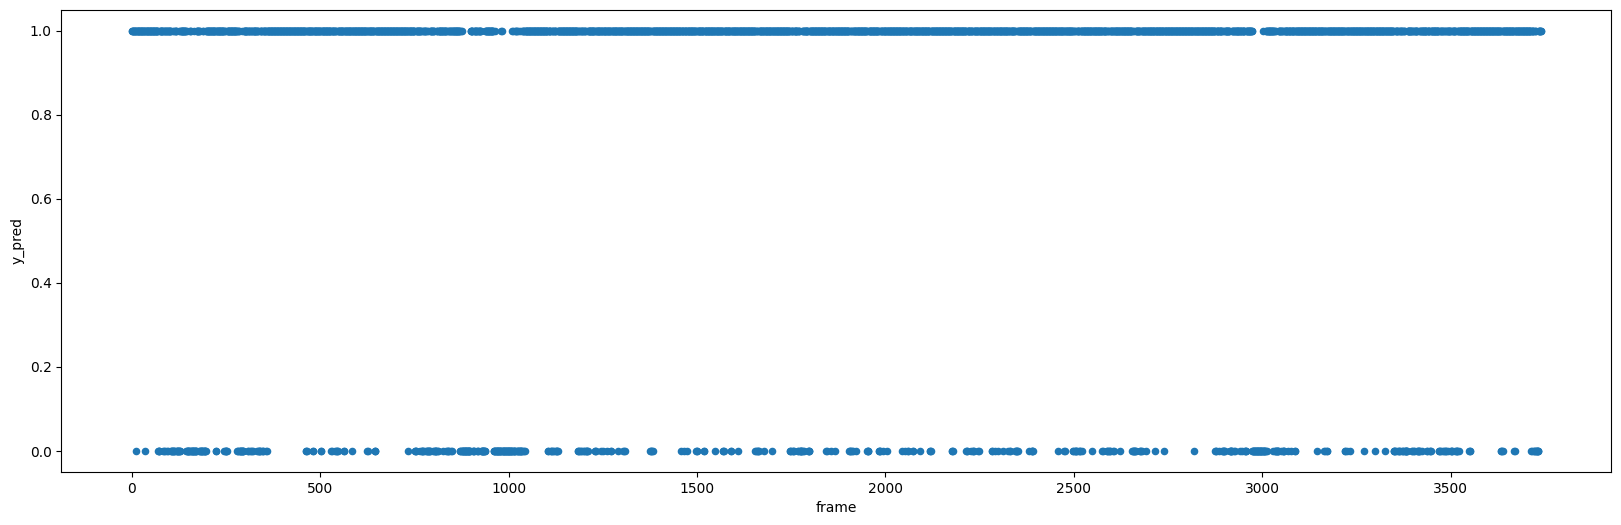

In [30]:
df.plot(x="frame", y="y_pred", kind="scatter", figsize=(20, 6))

### Модель

In [4]:
model = torch.load(
    './models/models/convnext_base.clip_laion2b_augreg_ft_in12k_in1k_scripted.pt'
)

C:\Users\itolo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [ ]:
for child in model.children():
    print("child", child)
    for nested_child in child.children():
        print("nested_child", nested_child)
        print()

In [7]:
import torch.nn as nn
from sklearn.metrics import f1_score

class RNN_NET(nn.Module):
    def __init__(self):
        super().__init__()
        
        model = torch.load(
            './models/models/convnext_base.clip_laion2b_augreg_ft_in12k_in1k_scripted.pt'
        )
                    
        childs = []
        for child in model.children():
            for nested_child in child.children():
                if str(nested_child) not in [
                    "RecursiveScriptModule(original_name=Identity)",
                    "RecursiveScriptModule(original_name=Dropout)",
                    "RecursiveScriptModule(original_name=Linear)"
                ]:
                    childs.append(nested_child)
                    
        self.backbone = nn.Sequential(*childs)
        
        self.fc_1 = nn.Linear(1024, 512)
        
        self.rnn = nn.RNN(512, 512, 1, batch_first=True, bidirectional=False)
        
        self.fc_2 = nn.Linear(1024, 256)
        self.fc_3 = nn.Linear(256, 2)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        with torch.no_grad():
            x = self.backbone(x)
        
        x = self.relu(self.fc_1(x))
        
        x, hn = self.rnn(x, None)
        x_mean = torch.mean(x, dim=0)
        x_max = torch.max(x, dim=0)[0]
        
        x = torch.cat((x_mean, x_max), dim=0)
        
        x = self.relu(self.fc_2(x))
        
        x = self.fc_3(x)
        
        return x

In [8]:
epochs = 5
batch_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
class Dataset_CRNN(Dataset):
    
    def __init__(self, data_path, target_path, transform=None):
        self.data_path = data_path
        self.target_path = target_path
        self.transform = transform

    def __len__(self):
        return max([int(x) for x in os.listdir(self.data_path)])

    def __getitem__(self, index):
        
        f = open(self.target_path + str(index) + "/" + "target.txt")
        labels = json.load(f)['frame']
        
        X, y_probs_all = [], []
        
        lst = os.listdir(self.data_path + str(index))
        frames_count = len(lst)
        
        for ind in lst:
            image = Image.open(self.data_path + str(index) + "/" + ind)

            if self.transform is not None:
                image = self.transform(image)

            X.append(image)
            y_probs_all.append(torch.FloatTensor(labels[ind.split(".")[0]]['all_probs']))
            
        X = torch.stack(X, dim=0)
        y_probs_all = torch.stack(y_probs_all, dim=0) 

        return X, y_probs_all

In [10]:
transform = T.Compose([T.ToTensor(), T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_set = Dataset_CRNN("frames/train/", "labeled_frames/", transform=transform)
val_set = Dataset_CRNN("frames/test/", "val_labeled_frames/", transform=transform)

train_loader = DataLoader(train_set, batch_size) # shuffle=True
valid_loader = DataLoader(val_set, batch_size)

In [11]:
def train(log_interval, crnn, device, train_loader, epoch, train_mode):
    scores, losses = {}, []
    
    global_targets, global_outputs = [], []
    global_y_preds, global_y_preds_probs = [], []
    
    targets, outputs = [], []
    y_preds, y_preds_probs = [], []
    
    each_n_batch_loop = 1
    
    for batch_idx, (X, y_probs_all) in enumerate(tqdm(train_loader)):
        X_batch, y_batch = X.to(device)[0], y_probs_all.to(device).reshape(y_probs_all.shape[1], 48)
        
        output = crnn(X_batch)
        output_soft_max = FF.softmax(output, dim=-1)
        
        y_pred_probs = output_soft_max[1]
        y_pred = torch.max(output_soft_max, 0)[1]
        y_batch = y_batch.cpu().detach().numpy()

        kl = sum(rel_entr(y_batch[1], y_batch[2])) # kl = sum(rel_entr(y_batch[0], y_batch[1]))
        target = torch.as_tensor(int(kl < 1), dtype=torch.long).to(device)

        global_targets.append(target.cpu().detach().numpy())
        global_outputs.append(output.cpu().detach().numpy())
        global_y_preds.append(y_pred.cpu().detach().numpy())
        global_y_preds_probs.append(y_pred_probs.cpu().detach().numpy())

        targets.append(target)
        y_preds.append(y_pred)
        y_preds_probs.append(y_pred_probs)
        outputs.append(output)
        
        loss = FF.cross_entropy(output, target)
        
        if train_mode:
            loss.backward()
            
        losses.append(loss.item())

        if len(targets) == each_n_batch_loop:

            targets = torch.Tensor(targets).type(torch.long).cpu()
            y_preds = torch.Tensor(y_preds).cpu()
            y_preds_probs = torch.Tensor(y_preds_probs).cpu()
            outputs = torch.stack(outputs, dim=0).cpu()
                     
            if train_mode:
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

            targets, outputs = [], []
            y_preds, y_preds_probs = [], []
        
    step_score_acc = accuracy_score(global_targets, global_y_preds)
    scores["accuracy"] = step_score_acc

    step_score_f1 = f1_score(global_targets, global_y_preds)
    scores["f1"] = step_score_f1
    
    step_score_gini = 2 * roc_auc_score(global_targets, global_y_preds_probs) - 1
    scores["gini"] = step_score_gini

    # show information
    info = "Test "
    if train_mode:
        info = "Train "
    if (batch_idx + 1) % log_interval == 0:
        print(info + 'Epoch:' + str(epoch + 1))
        print('Loss:' + str(round(np.mean(losses), 6)) + \
              ', Accu: ' + str(round(100 * step_score_acc, 2)) + \
              ", F1:" + str(round(100 * step_score_f1, 2)) + \
              ", Gini:" + str(round(100 * step_score_gini, 2)))

    return losses, scores["accuracy"], scores["f1"], scores["gini"], global_targets, global_y_preds

In [12]:
# import os
# os.environ["PATH"] += os.pathsep + 'C://Program Files//Graphviz//bin//'


(process:3940): Pango-WARNING **: 22:26:14.461: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


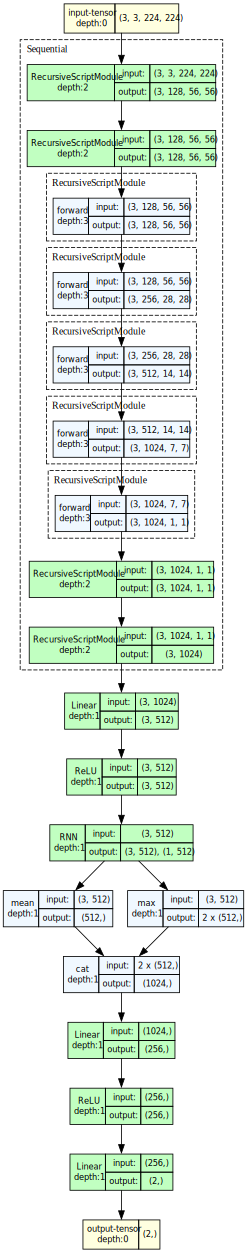

In [13]:
# from torchview import draw_graph

# model_graph = draw_graph(RNN_NET(), input_size=(3,3,224,224), expand_nested=True)
# model_graph.visual_graph

In [166]:
crnn = RNN_NET().to(device)

crnn_params = list(crnn.fc_1.parameters()) + \
              list(crnn.rnn.parameters()) + list(crnn.fc_2.parameters()) + list(crnn.fc_3.parameters())

optimizer = torch.optim.SGD(crnn_params, lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

from tqdm import tqdm
epoch_train_scores_acc, epoch_val_scores_acc = [], []
epoch_train_scores_f1, epoch_val_scores_f1 = [], []
epoch_train_scores_gini, epoch_val_scores_gini = [], []
epoch_train_losses, epoch_val_losses = [], []
targets, targets_val = [], []
y_preds, y_preds_val = [], []

for epoch in range(epochs):
    crnn.train()
    train_losses, train_scores_acc, train_scores_f1, train_scores_gini, target, y_pred = train(1, crnn, device, train_loader, epoch, True)
    
    crnn.eval()
    val_losses, val_scores_acc, val_scores_f1, val_scores_gini, val_target, val_y_pred = train(1, crnn, device, valid_loader, epoch, False)

    epoch_train_losses.append(train_losses)
    epoch_train_scores_acc.append(train_scores_acc)
    epoch_train_scores_f1.append(train_scores_f1)
    epoch_train_scores_gini.append(train_scores_gini)
    targets.append(target)
    y_preds.append(y_pred)
    
    epoch_val_losses.append(val_losses)
    epoch_val_scores_acc.append(val_scores_acc)
    epoch_val_scores_f1.append(val_scores_f1)
    epoch_val_scores_gini.append(val_scores_gini)
    targets_val.append(val_target)
    y_preds_val.append(val_y_pred)

A = np.array(epoch_train_losses)
B = np.array(epoch_train_scores_f1)
C = np.array(epoch_train_scores_acc)

D = np.array(epoch_val_losses)
E = np.array(epoch_val_scores_f1)
F = np.array(epoch_val_scores_acc)

100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:51<00:00, 27.64it/s]


Train Epoch:1
Loss:0.623646, Accu: 62.68, F1:74.62, Gini:30.12


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [01:37<00:00, 30.03it/s]


Test Epoch:1
Loss:0.575958, Accu: 73.63, F1:84.81, Gini:31.46


100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:48<00:00, 28.44it/s]


Train Epoch:2
Loss:0.556243, Accu: 69.15, F1:76.54, Gini:50.74


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [01:36<00:00, 30.56it/s]


Test Epoch:2
Loss:0.512904, Accu: 76.18, F1:85.72, Gini:45.54


100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:52<00:00, 27.37it/s]


Train Epoch:3
Loss:0.466248, Accu: 77.59, F1:82.5, Gini:69.53


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [01:44<00:00, 28.13it/s]


Test Epoch:3
Loss:0.508202, Accu: 77.34, F1:86.22, Gini:48.74


100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:53<00:00, 27.08it/s]


Train Epoch:4
Loss:0.410335, Accu: 81.88, F1:85.85, Gini:78.66


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [02:03<00:00, 23.77it/s]


Test Epoch:4
Loss:0.498446, Accu: 77.24, F1:85.74, Gini:49.64


100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:50<00:00, 27.94it/s]


Train Epoch:5
Loss:0.392975, Accu: 83.11, F1:86.73, Gini:80.9


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [02:01<00:00, 24.20it/s]

Test Epoch:5
Loss:0.496048, Accu: 77.17, F1:85.54, Gini:49.92


In [167]:
# torch.save(crnn.state_dict(), "./model_11_10_2024.pt")

In [96]:
# crnn = RNN_NET().to(device)

# crnn_params = list(crnn.fc_1.parameters()) + \
#               list(crnn.rnn.parameters()) + list(crnn.fc_2.parameters()) + list(crnn.fc_3.parameters())

# optimizer = torch.optim.SGD(crnn_params, lr=0.05)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

# from tqdm import tqdm
# epoch_train_scores_acc, epoch_val_scores_acc = [], []
# epoch_train_scores_f1, epoch_val_scores_f1 = [], []
# epoch_train_scores_gini, epoch_val_scores_gini = [], []
# epoch_train_losses, epoch_val_losses = [], []
# targets, targets_val = [], []
# y_preds, y_preds_val = [], []

# for epoch in range(epochs):
#     crnn.train()
#     train_losses, train_scores_acc, train_scores_f1, train_scores_gini, target, y_pred = train(1, crnn, device, train_loader, epoch, True)
    
#     crnn.eval()
#     val_losses, val_scores_acc, val_scores_f1, val_scores_gini, val_target, val_y_pred = train(1, crnn, device, valid_loader, epoch, False)

#     epoch_train_losses.append(train_losses)
#     epoch_train_scores_acc.append(train_scores_acc)
#     epoch_train_scores_f1.append(train_scores_f1)
#     epoch_train_scores_gini.append(train_scores_gini)
#     targets.append(target)
#     y_preds.append(y_pred)
    
#     epoch_val_losses.append(val_losses)
#     epoch_val_scores_acc.append(val_scores_acc)
#     epoch_val_scores_f1.append(val_scores_f1)
#     epoch_val_scores_gini.append(val_scores_gini)
#     targets_val.append(val_target)
#     y_preds_val.append(val_y_pred)

# A = np.array(epoch_train_losses)
# B = np.array(epoch_train_scores_f1)
# C = np.array(epoch_train_scores_acc)

# D = np.array(epoch_val_losses)
# E = np.array(epoch_val_scores_f1)
# F = np.array(epoch_val_scores_acc)

C:\Users\itolo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:50<00:00, 27.86it/s]


Train Epoch:1
Loss:0.613941, Accu: 64.99, F1:76.57, Gini:32.84


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [01:38<00:00, 29.93it/s]


Test Epoch:1
Loss:0.579086, Accu: 73.73, F1:84.79, Gini:37.45


100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:48<00:00, 28.42it/s]


Train Epoch:2
Loss:0.519138, Accu: 72.91, F1:79.78, Gini:58.38


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [01:37<00:00, 30.02it/s]


Test Epoch:2
Loss:0.520116, Accu: 76.15, F1:85.52, Gini:43.25


100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:48<00:00, 28.49it/s]


Train Epoch:3
Loss:0.406642, Accu: 81.78, F1:86.11, Gini:78.08


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [01:37<00:00, 30.21it/s]


Test Epoch:3
Loss:0.522154, Accu: 77.07, F1:86.03, Gini:48.42


100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:49<00:00, 28.23it/s]


Train Epoch:4
Loss:0.347672, Accu: 86.46, F1:89.66, Gini:85.55


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [01:37<00:00, 30.25it/s]


Test Epoch:4
Loss:0.497548, Accu: 77.31, F1:85.9, Gini:51.91


100%|██████████████████████████████████████████████████████████████████████████████| 3079/3079 [01:49<00:00, 28.23it/s]


Train Epoch:5
Loss:0.328602, Accu: 87.33, F1:90.31, Gini:87.57


100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [01:36<00:00, 30.37it/s]

Test Epoch:5
Loss:0.492468, Accu: 76.97, F1:85.4, Gini:52.44


In [97]:
# torch.save(crnn.state_dict(), "./model_10_10_2024.pt")

In [ ]:
# for epoch in range(epochs):
#     df_diff = pd.DataFrame({"target": targets[epoch], "y_pred": y_preds[epoch]})
#     print("epoch:", epoch)
#     print(df_diff["target"].value_counts())
#     print(df_diff["y_pred"].value_counts())
#     print("------------------------------------------------")

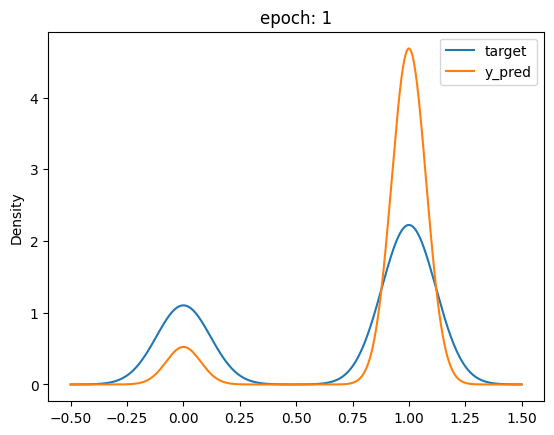

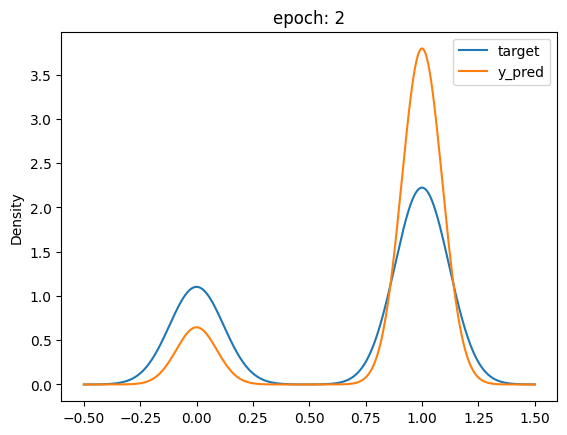

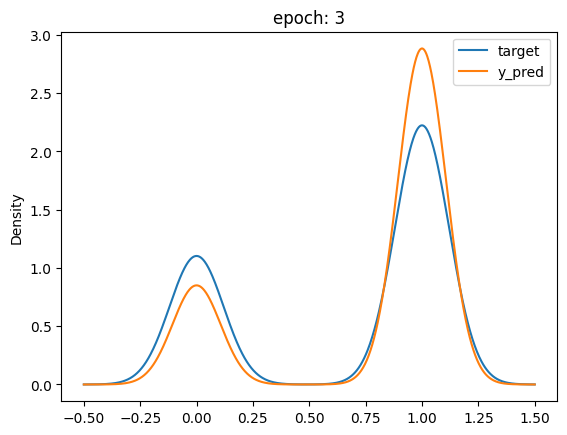

In [344]:
# for epoch in range(3):
#     df_diff = pd.DataFrame({"target": targets[epoch], "y_pred": y_preds[epoch]})
#     df_diff["target"] = df_diff["target"].astype(int)
#     df_diff["y_pred"] = df_diff["y_pred"].astype(int)
#     plt.title("epoch: " + str(epoch+1))
#     ax = df_diff["target"].plot(kind="kde")
#     ax = df_diff["y_pred"].plot(kind="kde", ax=ax)
#     plt.legend()
#     plt.show()